## Complilation with Open MP

In [108]:
!mkdir -p build
!cd build &&  cmake -DUSE_OMP=True -DUSE_CUDA=False -DCMAKE_BUILD_TYPE=Release .. &&  make

-- Traces are activated
-- Configuring done
-- Generating done
-- Build files have been written to: /home/cgomes/ot5/TP_AEVOL/build
Consolidate compiler generated dependencies of target micro_aevol
[ 83%] Built target micro_aevol
Consolidate compiler generated dependencies of target micro_aevol_cpu
[100%] Built target micro_aevol_cpu


In [6]:
#same as aboce but compile with ICX
!mkdir -p build
!cd build &&  cmake -DUSE_CUDA=False -DCMAKE_BUILD_TYPE=Release -DCMAKE_CXX_COMPILER=icpx -DCMAKE_C_COMPILER=icx .. &&  make

SYCL feature test compile failed!
compile output is: 
CMake Error at /home/cgomes/intel/oneapi/compiler/2022.2.1/linux/IntelDPCPP/IntelDPCPPConfig.cmake:276 (SYCL_FEATURE_TEST_EXTRACT):
  SYCL_FEATURE_TEST_EXTRACT Function invoked with incorrect arguments for
  function named: SYCL_FEATURE_TEST_EXTRACT
Call Stack (most recent call first):
  CMakeLists.txt:4 (find_package)


-- The SYCL compiler is /home/cgomes/intel/oneapi/compiler/2022.2.1/linux/bin/icpx
-- The SYCL Flags are --dpcpp -fsycl 
-- The SYCL Language Version is 202001
-- Traces are activated
CMake Error at /usr/share/cmake-3.22/Modules/FindPackageHandleStandardArgs.cmake:230 (message):
  Could NOT find OpenMP_CXX (missing: OpenMP_CXX_FLAGS OpenMP_CXX_LIB_NAMES)
Call Stack (most recent call first):
  /usr/share/cmake-3.22/Modules/FindPackageHandleStandardArgs.cmake:594 (_FPHSA_FAILURE_MESSAGE)
  /usr/share/cmake-3.22/Modules/FindOpenMP.cmake:544 (find_package_handle_standard_args)
  CMakeLists.txt:34 (find_package)


-- Con

## Compilation with CUDA

In [ ]:
!mkdir -p build
!cd build &&  cmake -DUSE_OMP=False -DUSE_CUDA=True .. &&  make

## Compilation in debug mode with Open MP

### For Intel Advisor

In [101]:
!mkdir -p build
!cd build && cmake .. -DUSE_OMP=True -DUSE_CUDA=False -DCMAKE_BUILD_TYPE=Debug && make

-- Traces are activated
-- Configuring done
-- Generating done
-- Build files have been written to: /home/cgomes/ot5/TP_AEVOL/build
Consolidate compiler generated dependencies of target micro_aevol
[  8%] Building CXX object CMakeFiles/micro_aevol.dir/Organism.cpp.o
[ 16%] Linking CXX static library libmicro_aevol.a
[ 83%] Built target micro_aevol
Consolidate compiler generated dependencies of target micro_aevol_cpu
[ 91%] Linking CXX executable micro_aevol_cpu
[100%] Built target micro_aevol_cpu


### For Gprof

In [ ]:
!mkdir -p build
!cd build && cmake .. -DUSE_OMP=True -DUSE_CUDA=False -DCMAKE_BUILD_TYPE=Debug -DCMAKE_CXX_FLAGS=-pg -DCMAKE_EXE_LINKER_FLAGS=-pg -DCMAKE_SHARED_LINKER_FLAGS=-pg && make

## Performance evaluation

In [109]:
import os
import subprocess
import glob
import subprocess

nrepeats = 15
nb_threads=6
# simulation_versionX_repeatX

subfolders = [ f.path for f in os.scandir("simulations") if f.is_dir() ]
folder_name = "simulation_" + str(len(subfolders))
os.mkdir("simulations/" + folder_name)
os.chdir("./simulations/" + folder_name)
print(os.getcwd())
print(folder_name)

for repeat in range(nrepeats):
    args = ("../../build/micro_aevol_cpu", "-T", str(nb_threads),"-R",str(repeat))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
    
os.chdir("../../")

/home/cgomes/ot5/TP_AEVOL/simulations/simulation_4
simulation_4


## Performance analysis

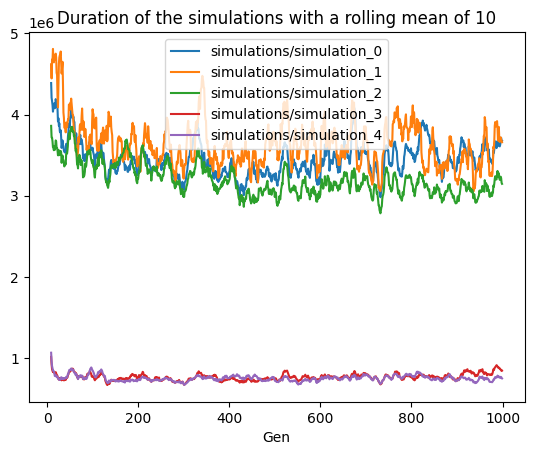

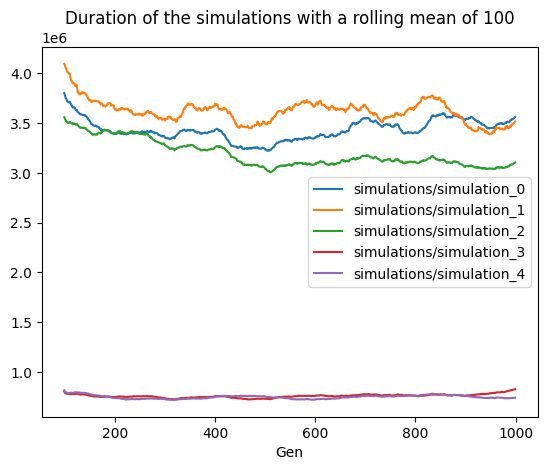

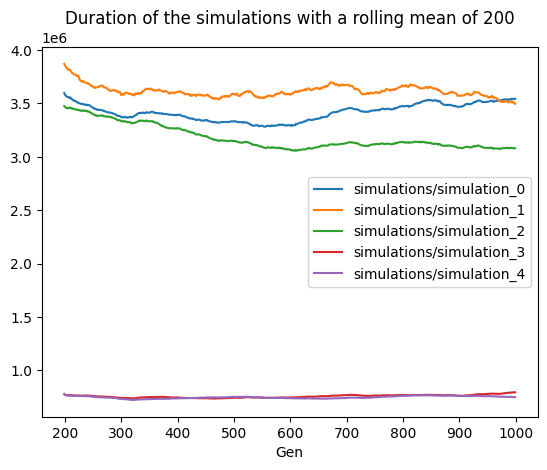

In [110]:
#create a dataframe with the mean of each simulation, with the index being 'Gen"
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

ABSOLUTE_PATH = "/home/cgomes/ot5/TP_AEVOL"
os.chdir(ABSOLUTE_PATH)

#read all the simulation folders in the simulations folder
subfolders = [ f.path for f in os.scandir("simulations") if f.is_dir() ]
subfolders.sort()

#read all the csv files in each simulation folder
simulations_list = []

for folder in subfolders:
    all_files = glob.glob(folder + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        df = df.iloc[1:]
        li.append(df)
    

    frame = pd.concat(li, axis=0).groupby('Gen').mean()
    simulations_list.append(frame)


for rolling in [10,100,200]:
    for simulation in simulations_list:
        simulation['duration'] = simulation['Duration'].astype(float)
        #create subplot by rolling value

        simulation['duration'].rolling(rolling).mean().plot(label=str(rolling))

        plt.legend(subfolders)
    plt.title("Duration of the simulations with a rolling mean of " + str(rolling))
    plt.show()
            



     Generation       fitness  metabolic_error  amount_of_dna  nb_coding_rnas  \
0             1  1.142680e-66         0.151837           5000               1   
1             2  1.142680e-66         0.151837           5000               1   
2             3  1.142680e-66         0.151837           5000               1   
3             4  2.905020e-58         0.132483           5000               1   
4             5  2.905020e-58         0.132483           5000               1   
5             6  2.905020e-58         0.132483           5000               1   
6             7  2.905020e-58         0.132483           5000               1   
7             8  2.905020e-58         0.132483           5000               1   
8             9  2.905020e-58         0.132483           5000               1   
9            10  2.905020e-58         0.132483           5000               1   
10           11  2.905020e-58         0.132483           5000               1   
11           12  2.905020e-5

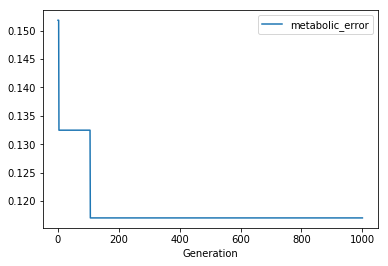

In [6]:

import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('build/simulation_example_1/stats/stats_simd_best.csv',header=0)
print(df)


df.plot(x='Generation', y = 'metabolic_error')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('build/simulation_example_1/stats/stats_simd_best.csv',header=0)
print(df)


df.plot(x='Generation', y = 'metabolic_error')

/tmp/ipykernel_453/706798827.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trace'].iloc[:len(df0)] = 0
/tmp/ipykernel_453/706798827.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trace'].iloc[len(df0):len(df0)+len(df1)] = 1
/tmp/ipykernel_453/706798827.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trace'].iloc[len(df0)+len(df1):] = 2


TypeError: Got both 'c' and 'color', which are aliases of one another

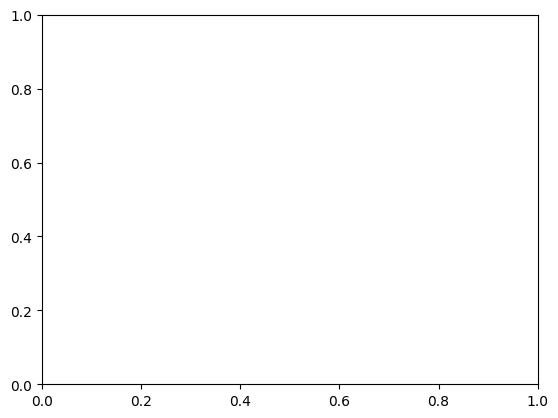

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

csv0_path = 'build/trace_1.csv'
csv1_path = 'build/trace_10.csv'

df0 = pd.read_csv(csv0_path,header=0)
df1 = pd.read_csv(csv1_path,header=0)


#remove 1st element of each dataframe
df0 = df0.iloc[1:]
df1 = df1.iloc[1:]

#concatenate and add a column to identify the dataframe with a name
df = pd.concat([df0, df1])
df['trace'] = np.where(df['Generation'] < 1000, 'trace_1', 'trace_10')


#group by trace, do the mean on Duration and plot
df.groupby('trace').mean().plot(y='Duration', kind='bar')



